# Protected Lands

This notebook merges FieldDoc protected lands with PASDA protected lands and plots the distribution of protection type in each cluster and subbasin.

# Setup

In [1]:
# Import packages
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
os.getcwd()

'C:\\Users\\clulay\\OneDrive - LimnoTech\\Documents\\GitHub\\pollution-assessment\\stage2'

In [3]:
# Import PADSA protected lands
pasda_gdf = gpd.read_file('./Protected_Lands/PASDA_protectedlands.shp')
pasda_gdf.head()

,OBJECTID,Category,sitename,esmthldr,eholdtype,own_name,own_type,URL,purpose,year_est,...,State,County,Municipali,Muni_Type,Muni,MMW,Shape_Leng,Shape_Area,RECLASS2,geometry
0,1,Government Agricultural Easement,A & A Likanchuk Enterprises,Cumberland County,Local,None,Private,http://www.co.cumberland.nj.us/content/22602/2...,Open Space - Farm,2019,...,New Jersey,Cumberland,Hopewell Township,Township,None,Agricultural Easement,3423.049486,187004.776462,Agricultural Easement,"POLYGON ((1751532.341 407777.856, 1751099.644 ..."
1,2,Government Agricultural Easement,A Massey And Mary G Moor Expansion Of The Mrs ...,Kent County,Local,None,Private,https://www.kentcounty.com/planning/ag-preserv...,Open Space - Farm,0,...,Delaware,Kent,Smyrna,None,None,Agricultural Easement,1916.706346,199885.340638,Agricultural Easement,"POLYGON ((1728392.832 383596.251, 1728323.430 ..."
2,3,Government Agricultural Easement,A. Robert & Elizabeth Masten Forestland Preser...,Kent County,Local,None,Private,https://www.kentcounty.com/planning/ag-preserv...,Open Space - Farm,0,...,Delaware,Kent,Milford North,None,None,Agricultural Easement,1072.469689,63712.037955,Agricultural Easement,"POLYGON ((1756477.929 358073.878, 1756369.596 ..."
3,4,Government Agricultural Easement,A. Robert Masten District,Kent County,Local,None,Private,https://www.kentcounty.com/planning/ag-preserv...,Open Space - Farm,0,...,Delaware,Kent,Milford North,None,None,Agricultural Easement,6217.552416,680776.321708,Agricultural Easement,"MULTIPOLYGON (((1753225.505 361043.830, 175325..."
4,5,Government Agricultural Easement,"Aaronson, Janet",Burlington County,Local,None,Private,http://www.co.burlington.nj.us/196/Farmland-Pr...,Open Space - Farm,2009,...,New Jersey,Burlington,Mansfield Township,Township,None,Agricultural Easement,1402.825687,108689.461184,Agricultural Easement,"POLYGON ((1785683.278 492347.560, 1785711.450 ..."


In [4]:
# Import FieldDoc protected lands 
fielddoc_gdf = gpd.read_parquet("G:/cl-WPFPA2/protection_df.parquet")
fielddoc_gdf.head()

huc12  \
comid   practice_id                 
2583191 54313        020401050101   
2583195 51275        020401050101   
        51282        020401050101   
        54313        020401050101   
2583199 51275        020401050101   

                                                         practice_name  \
comid   practice_id                                                      
2583191 54313        Culvers Brook Preserve II - Subject - Fee Acqu...   
2583195 51275        Culvers Brook Preserve - Reforested Area (to >...   
        51282            Culvers Brook Preserve - Active Forested Area   
        54313        Culvers Brook Preserve II - Subject - Fee Acqu...   
2583199 51275        Culvers Brook Preserve - Reforested Area (to >...   

                                                          program_name  \
comid   practice_id                                                      
2583191 54313        Delaware River Watershed Protection Fund - For...   
2583195 51275        Delaware River Watershed Protection Fund - For...   
        51282        Delaware River Watershed Protection Fund - For...   
        54313        Delaware River Watershed Protection Fund - For...   
2583199 51275        Delaware River Watershed Protection Fund - For...   

                     program_id                        organization  \
comid   practice_id                                                   
2583191 54313                 5  New Jersey Conservation Foundation   
2583195 51275                 5  New Jersey Conservation Foundation   
        51282                 5  New Jersey Conservation Foundation   
        54313                 5  New Jersey Conservation Foundation   
2583199 51275                 5  New Jersey Conservation Foundation   

                                                           description  \
comid   practice_id                                                      
2583191 54313                                                     None   
2583195 51275        The WRWMG plans to use its extensive watershed...   
        51282                                                     None   
        54313                                                     None   
2583199 51275        The WRWMG plans to use its extensive watershed...   

                       practice_type                       created_at  \
comid   practice_id                                                     
2583191 54313        Fee acquisition 2021-11-23 21:16:32.491086+00:00   
2583195 51275        Fee acquisition 2021-05-17 15:36:21.994724+00:00   
        51282        Fee acquisition 2021-05-18 15:55:27.834297+00:00   
        54313        Fee acquisition 2021-11-23 21:16:32.491086+00:00   
2583199 51275        Fee acquisition 2021-05-17 15:36:21.994724+00:00   

                                         modified_at  bmp_size bmp_size_unit  \
comid   practice_id                                                            
2583191 54313       2021-12-07 14:29:21.209918+00:00      8.52         ACRES   
2583195 51275       2021-05-19 21:13:17.662438+00:00      6.08         ACRES   
        51282       2021-05-18 18:12:55.445919+00:00      4.64         ACRES   
        54313       2021-12-07 14:29:21.209918+00:00    171.07         ACRES   
2583199 51275       2021-05-19 21:13:17.662438+00:00     18.95         ACRES   

                                                                  geom  
comid   practice_id                                                     
2583191 54313        MULTIPOLYGON (((-74.75218 41.16936, -74.75349 ...  
2583195 51275        MULTIPOLYGON (((-74.76719 41.16289, -74.76713 ...  
        51282        MULTIPOLYGON (((-74.76471 41.16496, -74.76433 ...  
        54313        MULTIPOLYGON (((-74.75349 41.16868, -74.76104 ...  
2583199 51275        MULTIPOLYGON (((-74.76935 41.16212, -74.76943 ...

In [5]:
# Import cluster and focus area geometries
cluster_gdf = gpd.read_parquet('../stage1/data/cluster_df.parquet')  
focusarea_gdf = gpd.read_parquet('../stage1/data/fa_phase2_df.parquet')
focusarea_gdf.cluster = focusarea_gdf.cluster.replace('Kirkwood Cohansey Aquifer', 'Kirkwood - Cohansey Aquifer') # update name for consistency with other files 
focusarea_gdf.set_index('name', inplace=True)

# Reproject coordinate systems

In [6]:
# Check coordinate systems
pasda_gdf.crs

<Derived Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
fielddoc_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
# Reproject CRS to 3857
pasda_gdf.to_crs(epsg=3857, inplace=True)
fielddoc_gdf.to_crs(epsg=3857, inplace=True)
focusarea_gdf.to_crs(epsg=3857, inplace=True)
cluster_gdf.to_crs(epsg=3857, inplace=True)

<AxesSubplot:>

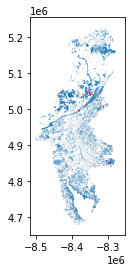

In [9]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax1 = plt.subplots()
pasda_gdf.plot(ax=ax1)
cmap = ListedColormap(['red'],name='allred')
fielddoc_gdf.plot(ax=ax1,cmap=cmap)

# Merge geodataframes

In [10]:
# Subset categories of pasda_gdf to eventually merge with fielddoc_gdf
pasda_simp_gdf = pasda_gdf[['sitename','esmthldr','purpose','RECLASS2','geometry']]
pasda_simp_gdf.rename(columns={'sitename': 'practice_name', 
                               'purpose': 'description',
                               'esmthldr': 'organization', 
                               'RECLASS2': 'practice_type',
                              'geometry': 'geom'}, inplace=True)
pasda_simp_gdf.head()

C:\Users\clulay\AppData\Local\Temp\ipykernel_31244\3409469126.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pasda_simp_gdf.rename(columns={'sitename': 'practice_name',


,practice_name,organization,description,practice_type,geom
0,A & A Likanchuk Enterprises,Cumberland County,Open Space - Farm,Agricultural Easement,"POLYGON ((-8382556.450 4783404.828, -8383286.4..."
1,A Massey And Mary G Moor Expansion Of The Mrs ...,Kent County,Open Space - Farm,Agricultural Easement,"POLYGON ((-8418778.799 4759440.280, -8418892.4..."
2,A. Robert & Elizabeth Masten Forestland Preser...,Kent County,Open Space - Farm,Agricultural Easement,"POLYGON ((-8390224.397 4719824.532, -8390437.6..."
3,A. Robert Masten District,Kent County,Open Space - Farm,Agricultural Easement,"MULTIPOLYGON (((-8393516.078 4724425.971, -839..."
4,"Aaronson, Janet",Burlington County,Open Space - Farm,Agricultural Easement,"POLYGON ((-8314559.794 4880366.861, -8314556.8..."


In [11]:
# Append field doc protected lands with pasda protected lands
all_pl_gdf = fielddoc_gdf.append(pasda_simp_gdf)

# Clean up all protected land gdf
all_pl_gdf = all_pl_gdf[['practice_name', 'program_name', 'organization',
                         'practice_type', 'geom']]

C:\Users\clulay\AppData\Local\Temp\ipykernel_31244\1487990246.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_pl_gdf = fielddoc_gdf.append(pasda_simp_gdf)


# Plot distribution of protected lands

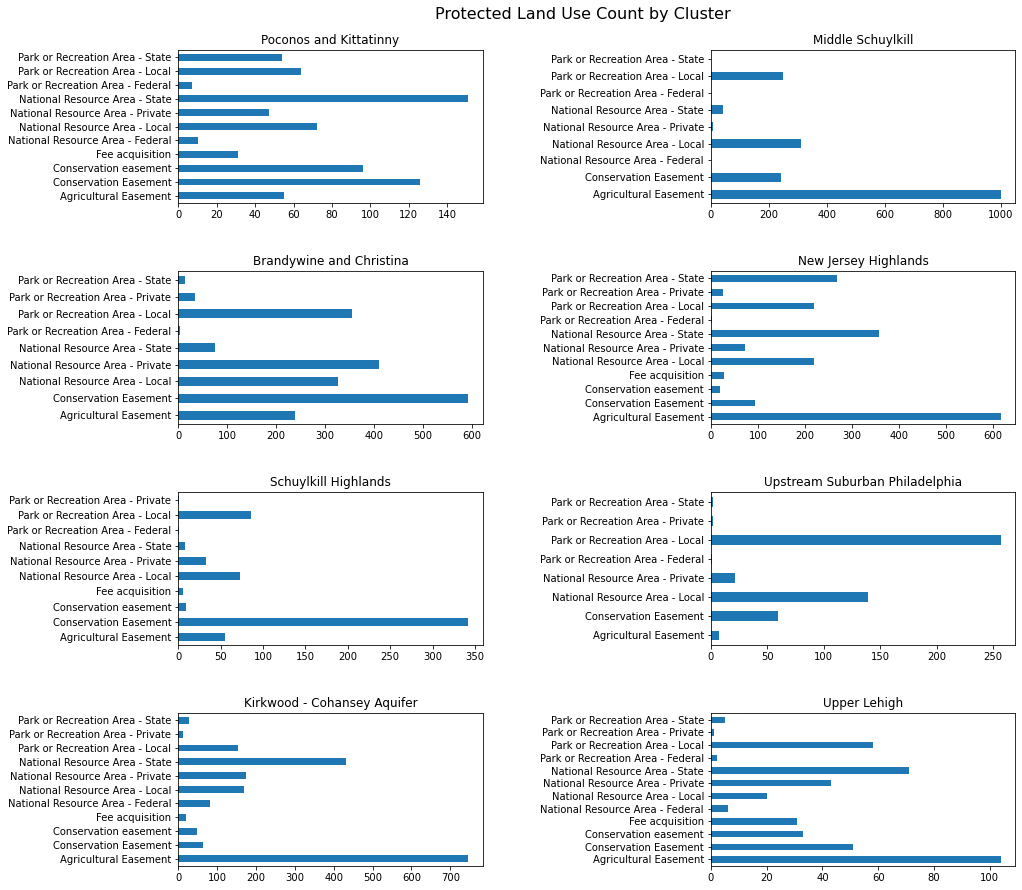

In [12]:
# Plot distribution of COUNTS for each cluster
fig, ax = plt.subplots(4,2, figsize=(15,15))
plt.subplots_adjust(hspace=0.45,wspace=0.75)
fig.suptitle('Protected Land Use Count by Cluster',fontsize=16,y=0.92)
n=0

#ind = 'Poconos and Kittatinny'
for ind in cluster_gdf.index:
    geom = cluster_gdf.loc[[ind]]
    in_cluster = all_pl_gdf.clip(geom)
    n = n+1
    ax = plt.subplot(4,2,n)
    
    in_cluster['practice_type'].value_counts().sort_index().plot(kind='barh', title=ind)

In [13]:
focusarea_gdf.index

Index(['Brandywine Creek Headwaters', 'Plum Run', 'Red Clay Creek',
       'White Clay Creek', 'Cohansey River', 'Lower Salem River', 'Menantico',
       'Muddy Run', 'Rancocas', 'Upper Salem River', 'Furnace Cr',
       'Hosensack Cr', 'Licking Cr', 'Lower Maiden Cr Trib 1',
       'Lower Maiden Cr Trib 3', 'Manatawny Trib 2', 'Manatawny Trib 3',
       'Manor Cr', 'Mill Cr Berger', 'Mill Cr Trib 2', 'Mill Cr Younker',
       'Moselem Cr', 'Tulpehocken Trib 2', 'Tulpehocken Trib 3',
       'Little Manatawny Trib 4', 'Lower Maiden Cr Trib 2',
       'Middle Maiden Trib', 'Northkill', 'Saucony Cr Trib 1',
       'Saucony Cr Trib 2', 'Beaver Brook', 'Lopatcong Creek',
       'Lower Middle Musconetcong', 'Paulinskill', 'Upper Musconetcong',
       'Brodhead', 'Cherry Valley', 'Eastern Mongaup', 'Little Bushkill',
       'Lower Bashakill', 'Lower Neversink', 'Rattlesnake Creek',
       'Upper Neversink', 'Hay Creek', 'Bryn Coed', 'Pigeon Run',
       'Pine Creek - French', 'Pine Creek - Pi

CPU times: total: 3.38 s
Wall time: 3.37 s


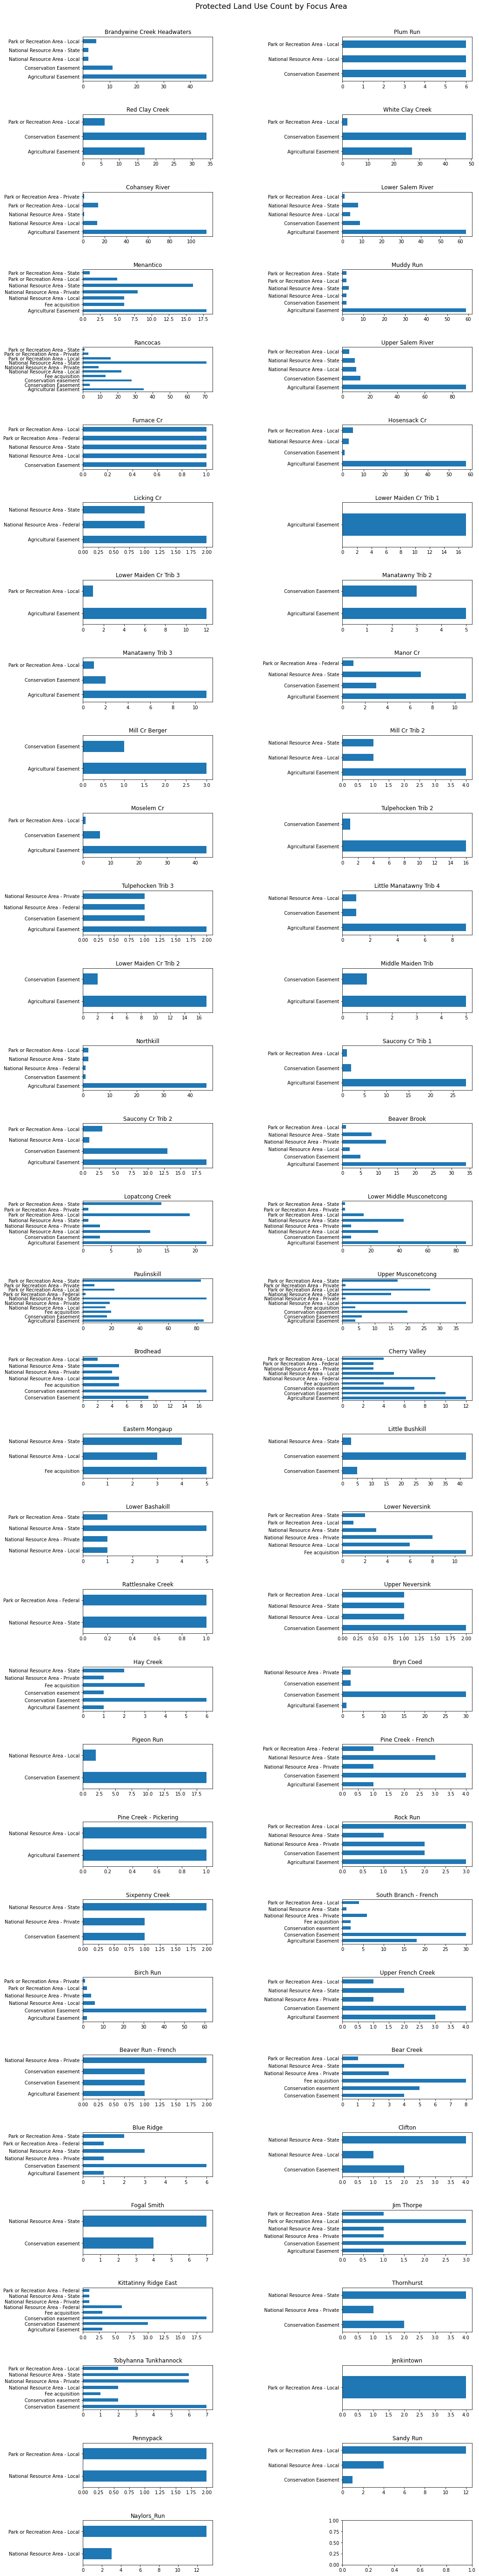

In [14]:
%%time
# Plot distribution of COUNTS for each focus area
fig, ax = plt.subplots(33,2, figsize=(15,100))
plt.subplots_adjust(hspace=0.75,wspace=1)
fig.suptitle('Protected Land Use Count by Focus Area',fontsize=16,y=0.89)
n=0

for ind in focusarea_gdf.index:
    geom = focusarea_gdf.loc[[ind]]
    in_fa = all_pl_gdf.clip(geom)
    
    if in_fa.size != 0:
        n = n+1
        ax = plt.subplot(33,2,n) 
        
        in_fa['practice_type'].value_counts().sort_index().plot(kind='barh', title=ind)

**TO DO: dissolve overlapping geometries, compute protected land areas, improve FA plots**